In [3]:
import re
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import defaultdict

from classes.utils import check_options, extract_option
PATH = "/Users/cinghio/Documents/PHD/HealthBranches/"
BENCH =  f"{PATH}results/results_QUIZ_bench_"
BASE =  f"{PATH}results/results_QUIZ_baseline_"
MEDQA =  f"{PATH}results-medqa/results_QUIZ_medqa_"

In [4]:
def change_line(df_old, df_new):
    # Itera sulle righe del secondo CSV
    for _, row in df_new.iterrows():
        idx = row["ID"]  # ID nel secondo CSV che corrisponde all'indice del primo CSV
        label = row["label"]
        
        if label == "1":
            df_old.at[idx, "correct_optio"] = row["correct_option"]
        elif label == "2":
            df_old.at[idx, "question"] = row["question"]

    return df_old

def evaluate_answers(file_path, model):
    df = pd.read_csv(file_path)
    # subset_df = pd.read_csv("/home/cc/PHD/HealthBranches/question_checked.csv")

    #df = df[~df['question'].isin(subset_df['question'])] # senza le checked
    # df = df[df['question'].isin(subset_df['question'])] # solo checked

    df['correct_answer'] = df['real']
    accs = []
    print(model)

    for col in [c for c in df.columns if c.startswith(("zero_shot", "one_shot"))]:
        df[f'{col}_choice'] = df[col].apply(extract_option)
        df[f'{col}_is_correct'] = df[f'{col}_choice'] == df['correct_answer']
        accuracy = df[f'{col}_is_correct'].mean()
        print(f'Accuracy for {col}: {accuracy:.2%}')
        accs.append(accuracy)
    
    accs.insert(0, model)

    return accs

def evaluate_answers_by_cond(file_path, model, condition_value=None):
    df = pd.read_csv(file_path)
    
    # Filter the DataFrame for the specific condition if provided.
    if condition_value is not None:
        df = df[df['name'] == condition_value]
    
    # Set up the correct answer column.
    df['correct_answer'] = df['real']
    accs = []

    # Loop through each relevant column (those starting with "zero_shot" or "one_shot").
    for col in [c for c in df.columns if c.startswith(("zero_shot", "one_shot"))]:
        df[f'{col}_choice'] = df[col].apply(extract_option)
        df[f'{col}_is_correct'] = df[f'{col}_choice'] == df['correct_answer']
        accuracy = df[f'{col}_is_correct'].mean()
        # print(f'Accuracy for {col} under condition  == {condition_value}: {accuracy:.2%}')
        # if accuracy < 0.5:
        #      print(f'Accuracy for {col} under condition  == {condition_value}: {accuracy:.2%}')
        accs.append(accuracy)
    
    accs.insert(0, model)
    accs.insert(0, condition_value)
    return accs

def find_incorrect_indices(file_path, model):
    df = pd.read_csv(file_path)
    subset_df = pd.read_csv("/home/cc/PHD/HealthBranches/question_checked.csv")

    #df = df[~df['question'].isin(subset_df['question'])] # senza le checked
    # df = df[df['question'].isin(subset_df['question'])] # solo checked
    print(f"dataframe shape: {df.shape}, model: {model}")

    incorrect_indices = df.index[df["zero_shot"].apply(extract_option) != df["real"]].tolist()
    return incorrect_indices

def find_common_wrongs(lists_of_indices):
    if not lists_of_indices:
        return []
    
    # Start with the set of indices from the first list
    common = set(lists_of_indices[0])
    
    # Intersect with the indices from each subsequent list
    for indices in lists_of_indices[1:]:
        common &= set(indices)
    
    # Return the sorted list of common indices
    return sorted(common)

def create_folder_file_dict(root_folder):
    folder_dict = {}
    # List all items in the root folder
    for item in os.listdir(root_folder):
        item_path = os.path.join(root_folder, item)
        # Check if the item is a directory (folder)
        if os.path.isdir(item_path):
            # List all files in this subfolder
            files = os.listdir(item_path)
            # Optionally, filter out directories if needed:
            files = [f.lower().split('.')[0] for f in files if os.path.isfile(os.path.join(item_path, f))]
            folder_dict[item] = files
    return folder_dict

In [ ]:
df = pd.read_csv("/home/cc/PHD/HealthBranches/results/results_QUIZ_bench_DeepSeek-R1-Distill-Qwen-7B.csv")

for row in df.iterrows():
    if extract_option(df["zero_shot"]) == None:
        print(df["zero_shot"].values)

#evaluate_answers(BENCH + "DeepSeek-R1-Distill-Qwen-7B.csv", "DeepSeek-R1-Distill-Qwen-7B")

In [6]:
models = ["mistral_7b", "gemma_7b", "gemma2_9b", "gemma3_4b", "llama3.1_8b", "qwen2.5_7b", 
          "phi4_14b", "llama2_7b", "Llama-3.3-70B-Instruct-Turbo-Free"]
bench = [evaluate_answers(f"{BENCH}{model}.csv", model) for model in models]
baseline = [evaluate_answers(f"{BASE}{model}.csv", model) for model in models]

mistral_7b
Accuracy for zero_shot: 51.88%
Accuracy for zero_shot_rag: 61.30%
gemma_7b
Accuracy for zero_shot: 57.00%
Accuracy for zero_shot_rag: 62.38%
gemma2_9b
Accuracy for zero_shot: 68.74%
Accuracy for zero_shot_rag: 72.06%
gemma3_4b
Accuracy for zero_shot: 51.25%
Accuracy for zero_shot_rag: 52.47%
llama3.1_8b
Accuracy for zero_shot: 67.03%
Accuracy for zero_shot_rag: 68.74%
qwen2.5_7b
Accuracy for zero_shot: 68.52%
Accuracy for zero_shot_rag: 69.03%
phi4_14b
Accuracy for zero_shot: 72.68%
Accuracy for zero_shot_rag: 73.39%
llama2_7b
Accuracy for zero_shot: 19.67%
Accuracy for zero_shot_rag: 29.55%
Llama-3.3-70B-Instruct-Turbo-Free
Accuracy for zero_shot: 75.42%
Accuracy for zero_shot_rag: 76.32%
mistral_7b
Accuracy for zero_shot: 80.58%
gemma_7b
Accuracy for zero_shot: 78.20%
gemma2_9b
Accuracy for zero_shot: 87.72%
gemma3_4b
Accuracy for zero_shot: 67.22%
llama3.1_8b
Accuracy for zero_shot: 78.01%
qwen2.5_7b
Accuracy for zero_shot: 89.21%
phi4_14b
Accuracy for zero_shot: 79.26%
l

In [9]:
conditions = pd.read_csv(f"{PATH}results/results_QUIZ_baseline_Llama-3.3-70B-Instruct-Turbo-Free.csv")['name'].unique().tolist()
cats = create_folder_file_dict(f"{PATH}new_trees")

res_bench = []
res_base = []
for model in models:
    for condition in conditions:
        accs = evaluate_answers_by_cond(f"{BENCH}{model}.csv", model, condition)
        res_bench.append(accs)
        accs = evaluate_answers_by_cond(f"{BASE}{model}.csv", model, condition)
        res_base.append(accs)

In [10]:
file_to_folder = {}
for folder, files in cats.items():
    for file in files:
        file_to_folder[file] = folder

# Step 2: Replace the first element in each sublist with the corresponding folder name
for sublist in res_bench:
    file_name = sublist[0]
    if file_name in file_to_folder:
        sublist[0] = file_to_folder[file_name]
    else:
        # Handle the case where the file name is not found in the dictionary
        sublist[0] = 'Unknown Folder'

for sublist in res_base:
    file_name = sublist[0]
    if file_name in file_to_folder:
        sublist[0] = file_to_folder[file_name]
    else:
        # Handle the case where the file name is not found in the dictionary
        sublist[0] = 'Unknown Folder'

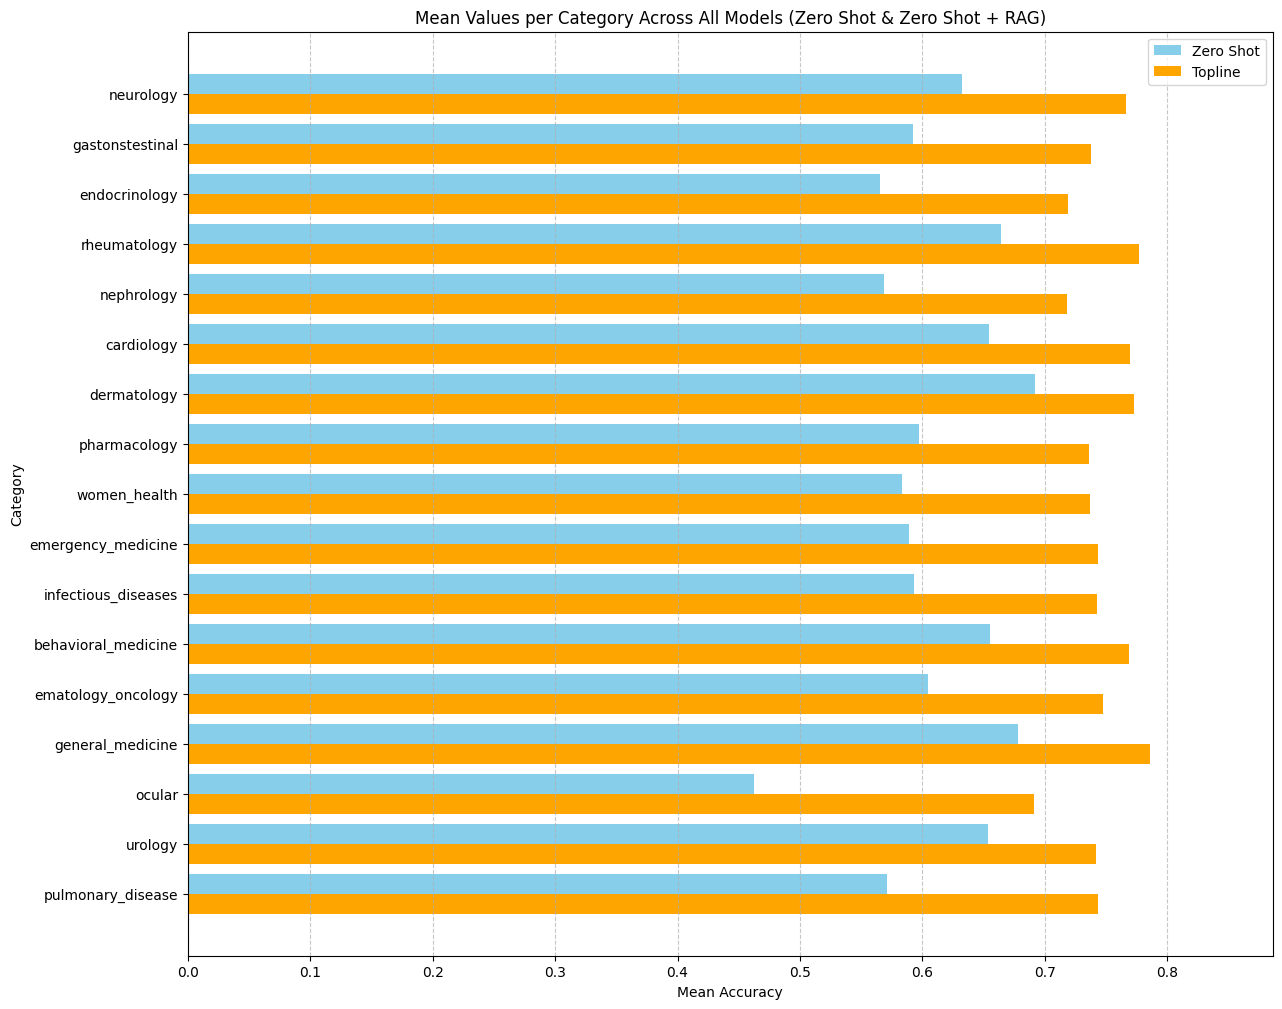

In [ ]:
# Step 1: Organize values per category for both columns
category_values1 = defaultdict(list)
category_values2 = defaultdict(list)

for item in res_bench:
    category = item[0].replace("trees_", "")  # Remove "trees_" prefix
    value1 = float(item[2])  # First value column
    value2 = float(item[3])  # Second value column
    category_values1[category].append(value1)
    category_values2[category].append(value2)

# for item in res_base:
#     category = item[0].replace("trees_", "")  # Remove "trees_" prefix
#     value1 = float(item[2])  # First value column
#     category_values2[category].append(value2)

# Compute mean for each category for both value columns
mean_values1 = {category: np.mean(values) for category, values in category_values1.items()}
mean_values2 = {category: np.mean(values) for category, values in category_values2.items()}

# Step 2: Extract names and mean values for plotting
names = list(mean_values1.keys())
values1 = [mean_values1[category] for category in names]
values2 = [mean_values2[category] for category in names]

# Create y positions for categories and bar offsets
y_pos = np.arange(len(names))
bar_height = 0.4

# Step 3: Create the horizontal bar chart
plt.figure(figsize=(14, 12))
# Plot value1 bars shifted up
bars1 = plt.barh(y_pos - bar_height/2, values1, height=bar_height, color='skyblue', label='Zero Shot')
# Plot value2 bars shifted down
bars2 = plt.barh(y_pos + bar_height/2, values2, height=bar_height, color='orange', label='Topline')

# Set x-axis limits for proper scaling
all_values = values1 + values2
plt.xlim(0, max(all_values) + 0.1)

# # Add value labels on bars for both sets
# for bar in bars1:
#     plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", va='center')
# for bar in bars2:
#     plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", va='center')

# Labels, title, and legend
plt.xlabel('Mean Accuracy')
plt.ylabel('Category')
plt.title('Mean Values per Category Across All Models (Zero Shot & Zero Shot + RAG)')
plt.yticks(y_pos, names)
plt.legend()

# Invert y-axis to keep the first item on top
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
models = ["mistral:7b", "gemma:7b", "gemma2:9b", "llama3.1:8b", "qwen2.5:7b", "phi4:14b"]
wrongs = [find_incorrect_indices(f"{BASE}{model}.csv", model) for model in models]
w2 = [find_incorrect_indices(f"{BENCH}{model}.csv", model) for model in models]

In [ ]:
len(find_common_wrongs(wrongs+w2))

In [ ]:
df = pd.read_csv(f"{BASE}{"gemma2:9b"}.csv")
subset_df = pd.read_csv("/home/cc/PHD/HealthBranches/question_checked.csv")

#df = df[~df['question'].isin(subset_df['question'])] # senza le checked
df = df[df['question'].isin(subset_df['question'])] # solo checked
filtered_df = df.loc[find_common_wrongs(wrongs+w2)]
print(f"filtered_df shape: {filtered_df.shape}")

# Save the filtered dataframe to a CSV file without writing the index column
# filtered_df.to_csv("/home/cc/PHD/HealthBranches/questions_to_check_BASE.csv", index=False)

In [ ]:
print("### BASELINE ###")
for model in models:
    print(f"Results for {model}")
    evaluate_answers(f"{BASE}{model}.csv", model)

In [ ]:
print("### BENCH ###")
for model in models:
    print(f"Results for {model}")
    evaluate_answers(f"{BENCH}{model}.csv", model)

In [ ]:
print("### MEDQA ###")
for model in models:
    print(f"Results for {model}")
    evaluate_answers(f"{MEDQA}{model}.csv", model)

In [ ]:
def show_chart(bench, baseline, bar1, bar2, bar3, xl, yl, title):
    # Creiamo un dizionario dalla lista baseline per una ricerca veloce
    baseline_dict = {item[0]: item[1] for item in baseline}

    # Uniamo le liste
    merged_list = [item + [baseline_dict[item[0]]] for item in bench if item[0] in baseline_dict]

    # Ordiniamo la lista in base al primo float (item[1])
    merged_list.sort(key=lambda x: x[1], reverse=True)

    print(merged_list)

    # Estrai le etichette e i valori
    labels = [x[0] for x in merged_list]
    values1 = [x[1] for x in merged_list]
    values2 = [x[2] for x in merged_list]
    values3 = [x[3] for x in merged_list]

    # Imposta la posizione delle barre con più spazio tra i gruppi
    x = np.arange(len(labels)) * 1.3  # Moltiplica per aumentare la distanza tra i gruppi
    width = 0.35  # Larghezza delle barre

    # Aumenta le dimensioni del grafico
    fig, ax = plt.subplots(figsize=(16, 10))
    bars1 = ax.bar(x - width, values1, width, label=bar1)
    bars2 = ax.bar(x, values2, width, label=bar2)
    bars3 = ax.bar(x + width, values3, width, label=bar3)    

    # Etichette e titolo
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Mostra il grafico
    plt.show()

show_chart(bench, baseline, "no RAG", "RAG", "Baseline", "Models", "Accuracy", "Benchmark")

In [ ]:
import pandas as pd
import ast
import random
import string
from collections import Counter

def balance_correct_answer(csv_file, output_file):
    # Carica il file CSV
    df = pd.read_csv(csv_file)
    
    # Definisce le lettere per le opzioni (A, B, C, D, E)
    option_letters = list(string.ascii_uppercase[:5])
    
    # Conta la distribuzione attuale delle risposte corrette
    correct_counts = Counter(df['correct_option'])
    
    # Calcola il numero desiderato per ciascuna lettera
    target_count = len(df) // 5
    
    # Inizializza un dizionario per tenere traccia delle assegnazioni
    assigned_counts = {letter: 0 for letter in option_letters}
    
    # Funzione per ribilanciare la posizione della risposta corretta
    def rebalance(row):
        options = ast.literal_eval(row['options'].replace("['", '["').replace("']", '"]').replace("', '", '", "'))  # Converte la stringa in lista
        correct_letter = row['correct_option']
        correct_index = option_letters.index(correct_letter)
        correct_answer = options[correct_index]
        
        # Trova le lettere meno usate
        available_letters = [letter for letter in option_letters if assigned_counts[letter] < target_count]
        
        # Se tutte le lettere sono bilanciate, assegna a caso
        new_correct_letter = random.choice(available_letters) if available_letters else random.choice(option_letters)
        new_correct_index = option_letters.index(new_correct_letter)
        
        # Rimescola le risposte
        random.shuffle(options)
        
        # Sposta la risposta corretta nella nuova posizione
        options.remove(correct_answer)
        options.insert(new_correct_index, correct_answer)
        
        # Aggiorna il conteggio
        assigned_counts[new_correct_letter] += 1
        
        return pd.Series([str(options), new_correct_letter])
    
    # Applica la funzione a ogni riga
    df[['options', 'correct_option']] = df.apply(rebalance, axis=1)
    
    # Salva il nuovo file CSV
    df.to_csv(output_file, index=False)

    return df


df = pd.read_csv("/home/cc/PHD/HealthBranches/questions_pro/ultimate_questions_v3_full.csv")
print("Distribuzione prima:")
print(Counter(df["correct_option"]))

# # Esegui la funzione su un file di esempio
# bal_df = balance_correct_answer("/home/cc/PHD/HealthBranches/questions_pro/ultimate_questions_v3_full.csv", "/home/cc/PHD/HealthBranches/questions_pro/ultimate_questions_v3_full_balanced.csv")

# # df = balance_correct_options(df)
# print("Distribuzione dopo:")
# print(Counter(bal_df["correct_option"]))

# df.to_csv("/home/cc/PHD/HealthBranches/questions_pro/ultimate_questions_v3_full_balanced.csv", index=False)

In [ ]:
# Carica i CSV
df_dataset = pd.read_csv('/home/cc/PHD/HealthBranches/questions_pro/ultimate_questions_v3_full_balanced.csv')       # CSV completo delle domande
df_subset = pd.read_csv('/home/cc/PHD/HealthBranches/questions_to_check.csv')         # CSV con le domande da correggere
df_corrected = pd.read_csv('/home/cc/PHD/HealthBranches/question_checked.csv')    # CSV con le domande corrette; contiene la colonna "ID" (l'indice nel CSV subset)

# Resetta l'indice di df_subset per garantire che sia numerato da 0 a len(df_subset)-1
# df_subset.reset_index(drop=True, inplace=True)

mapping = {}
for _, row in df_corrected.iterrows():
    idx = int(row['ID'])
    if idx < len(df_subset):
        original_question = df_subset.loc[idx, 'question']
        mapping[original_question] = {
            'question': row['question'],
            'answer': row['answer'],
            'options': row['options'],
            'correct_option': row['correct_option'],
            'path': row['path']
        }
    else:
        print(f"Warning: ID {idx} non presente in df_subset")

# Funzione per aggiornare una riga del dataset, se la domanda è presente nel mapping
def update_row(row):
    corrections = mapping.get(row['question'])
    if corrections:
        row['question'] = corrections['question']
        row['answer'] = corrections['answer']
        row['options'] = corrections['options']
        row['correct_option'] = corrections['correct_option']
        row['path'] = corrections['path']
    return row

# Applica la funzione a ogni riga del dataset
df_dataset = df_dataset.apply(update_row, axis=1)
df_dataset.drop(columns=['answer'], inplace=True)

# Salva il dataset aggiornato
df_dataset.to_csv('dataset_updated.csv', index=False)
print("Dataset aggiornato salvato come 'dataset_updated.csv'")